# FORECASTING BUS DEMAND

In [25]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from prophet import Prophet

In [26]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all raws
pd.set_option('display.float_format', lambda x: '%.3f' %
              x)
pd.set_option('display.width', 500)

In [27]:
MUNICIPALITY_COUNT = 10
TOTAL_DATA_RAW_COUNT = 13070
TOTAL_DATA_FEATURE_COUNT = 4
EACH_MUNICIPALITY_DATA_RAW_COUNT = TOTAL_DATA_RAW_COUNT/MUNICIPALITY_COUNT
FIRST_DATE = "2017-06-04"
LAST_DATE = "2017-08-19"
TIME_COLUMN_NAME = "timestamp"
MUNICIPALITY_COLUMN_NAME = "municipality_id"
USAGE_COLUMN_NAME = "usage"
TEST_DATA_INDEX_NUMBER = 150

In [28]:
def check_df(dataframe, head=10):
    '''
    Provides general information about the loaded data.

    Parameters
    ----------
    dataframe: dataframe
    head: int

    Notes
    ----------
    The head value is set to a constant 5.
    '''
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("##################### Corr #####################")
    print(dataframe.corr())
    print("##################### Describe #####################")
    print(dataframe.describe())

### Split dataset by municipality numbers

In [29]:
def sprit_municipality(data,municipality_column_name):
    ''' 
    Allows the given dataset to be sorted by municipality numbers.
    
    Parameters
    ----------
    data: dataframe
    municipality_column_name: str

    Returns
    -------
    df: dataframe
    '''
    df = pd.DataFrame()

    for idx in range(MUNICIPALITY_COUNT):
        each_municipality = data.groupby([municipality_column_name]).get_group(idx)
        df = pd.concat([df,each_municipality], ignore_index=True)
    
    return df

In [30]:
def selecet_max_usage_in_an_hour(data,time_column_name,municipality_column_name,first_character_count=13):
    '''
    It serves to select the one with the maximum value from the measurements within the 1-hour period in the data set.

    Parameters
    ----------
    data: dataframe
    time_column_name: str
    municipality_column_name: str
    first_character_count: int

    Notes
    -----
    first_character_count is set to 13 depending on the time display structure. Because our goal is to determine the measurements within 1 hour.

    Returns
    -------
    data: dataframe
    '''
    data[time_column_name] = data.timestamp.apply(lambda x: x[:first_character_count])
    data = data.groupby([time_column_name,municipality_column_name]).agg({'usage':'max','total_capacity':'max'}).reset_index()
    data.timestamp = pd.to_datetime(data.timestamp)
    # data = sprit_municipality(data,municipality_column_name)

    return data

### Missing Data Detect

In [31]:
def find_missing_dates(data,time_column_name):
    '''
    It allows to detect missing days in the data.

    Parameters
    ----------
    data: dataframe
    time_column_name: str

    Returns
    -------
    missing_dates: list
        List of missing date
    
    '''
    tempdf = data.copy()
    tempdf = tempdf[time_column_name].apply(lambda date: datetime.datetime.strptime(str(date)[:str(date).find(' ')], "%Y-%m-%d"))
    missing_dates = pd.date_range(start=FIRST_DATE, end=LAST_DATE).difference(tempdf.values)
    return missing_dates

In [32]:
def find_missing_hours(data,time_column_name,municipality_column_name):
    '''
    It allows to detect missing hours in the data.

    Parameters
    ----------
    data: dataframe
    time_column_name: str
    municipality_column_name: str

    Returns
    -------
    missing: dict
        dict of missing hours.
    '''
    temp = data[[time_column_name, municipality_column_name]].set_index(time_column_name)
    rec_hours = temp[temp[municipality_column_name] == 0].loc[FIRST_DATE].index.hour

    data = data[[time_column_name, municipality_column_name]].set_index(time_column_name).copy()
    
    missing = {}
    for day in pd.date_range(FIRST_DATE, LAST_DATE):
        hrs = temp[temp[municipality_column_name] == 0].loc[str(day.date())].index.hour.to_list()
        missing_hours = set(rec_hours.to_list()).difference(hrs)
        if (missing_hours != set()):
            missing[str(day.date())] = missing_hours

    return missing

### Filling Missing Data

In [33]:
def create_missing_dataframe(missing_hours,time_column_name,municipality_column_name,usage_column_name):    
    missing_dates = []
    for day in pd.date_range(FIRST_DATE, LAST_DATE):
        if (str(day.date()) in missing_hours):
            new_date = [day.replace(hour=hour) for hour in missing_hours[str(day.date())]]
            missing_dates.extend(new_date)

    missing_muni = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] * len(missing_dates)
    missing_dates = sorted(missing_dates*10)
    missing_usage = [np.nan] * len(missing_muni) 
    missing_df = pd.DataFrame(data={time_column_name: missing_dates, 
                                    municipality_column_name: missing_muni, 
                                    usage_column_name: missing_usage})
    
    return missing_df

In [34]:
def mean_each_hour(data,time_column_name,municipality_column_name,usage_column_name):
    
    temp = data[[time_column_name, municipality_column_name]].set_index(time_column_name)
    rec_hours = temp[temp[municipality_column_name] == 0].loc[FIRST_DATE].index.hour

    means = {}
    for muni in data[municipality_column_name].unique():
        temp = data[data[municipality_column_name] == muni].set_index(time_column_name)
        for hr in rec_hours:
            means[f'{muni}_{hr}'] = np.mean(temp[temp.index.hour == hr][usage_column_name])
    
    return means

In [35]:
def fill_all_missing_values(data,missing_df,means,time_column_name,municipality_column_name):

    missing_df = missing_df.set_index(time_column_name)
    for muni in data[municipality_column_name].unique():
        for hr in rec_hours:
            missing_df[(missing_df[municipality_column_name] == muni) & (missing_df.index.hour == hr)] = missing_df[(missing_df[municipality_column_name] == muni) & (missing_df.index.hour == hr)].fillna(means[f'{muni}_{hr}'])

    final_df = pd.concat((data.set_index(time_column_name), missing_df))
    final_df = final_df.sort_index()

    return final_df

In [36]:
def save_clean_data_as_csv(clean_data,municipality_column_name):

    for muni in clean_data[municipality_column_name].unique():  
        clean_data[clean_data[municipality_column_name] == muni].to_csv(f'data/preprocessed/municipality_{muni}.csv', index=True)

### Fit Model and Predict

In [37]:
def prophet_model_predict_and_plot(municipality_id):

    data_municipality_0 = pd.read_csv(f'data/preprocessed/municipality_{municipality_id}.csv',header=0).drop('municipality_id', axis=1)
    data_municipality_0['timestamp'] = data_municipality_0['timestamp'].apply(lambda date: datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S"))
    data_municipality_0 = data_municipality_0.drop(["total_capacity"],axis=1)

    data_municipality_0.columns = ["ds","y"]

    train_data = data_municipality_0.drop(data_municipality_0.index[-TEST_DATA_INDEX_NUMBER:])
    test_data = data_municipality_0.loc[data_municipality_0.index[-TEST_DATA_INDEX_NUMBER:]]

    model = Prophet()
    model.fit(train_data)

    test_result = model.predict(test_data)

    fig, ax = plt.subplots(figsize=(10, 5))
    fig = model.plot(test_result, ax=ax)
    ax.set_title(f'Prophet Forecast {municipality_id}')

    fig = model.plot_components(test_result)
    plt.show()

### MAIN

##################### Shape #####################
(13070, 4)
##################### Types #####################
timestamp          object
municipality_id     int64
usage               int64
total_capacity      int64
dtype: object
##################### Head #####################
             timestamp  municipality_id  usage  total_capacity
0  2017-06-04 07:59:42                9    454            1332
1  2017-06-04 07:59:42                8    556            2947
2  2017-06-04 07:59:42                4   1090            3893
3  2017-06-04 07:59:42                0    204            2813
4  2017-06-04 07:59:42                7    718            2019
5  2017-06-04 07:59:42                5     70             587
6  2017-06-04 07:59:42                2    273             697
7  2017-06-04 07:59:42                1    129             397
8  2017-06-04 07:59:42                6    597            3113
9  2017-06-04 07:59:42                3    623            1930
##################### Tail ##

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

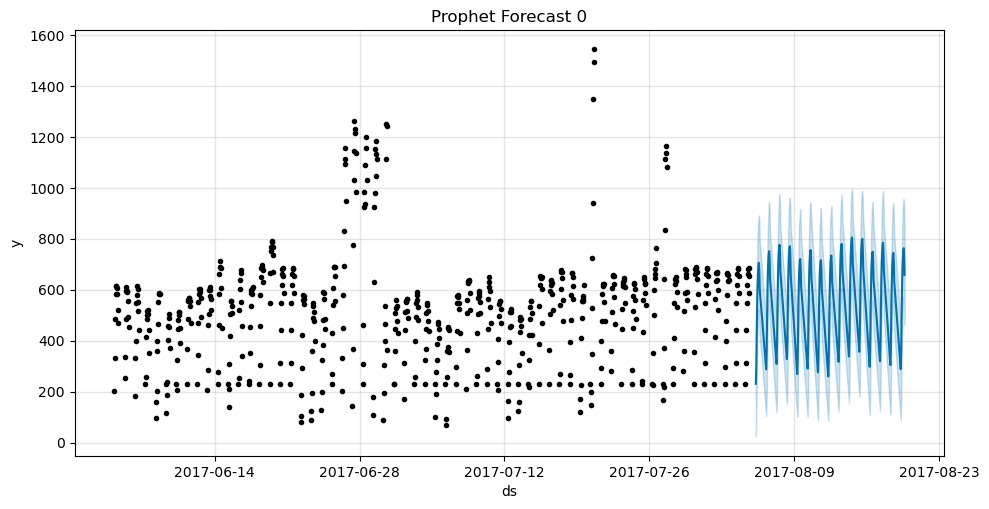

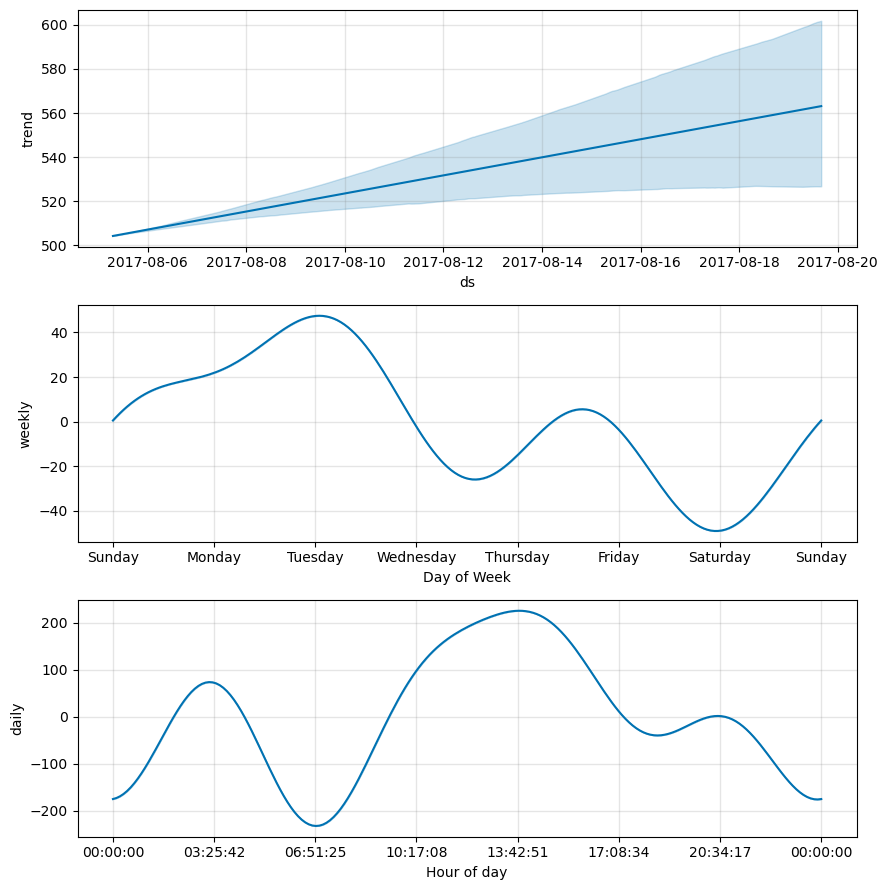

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

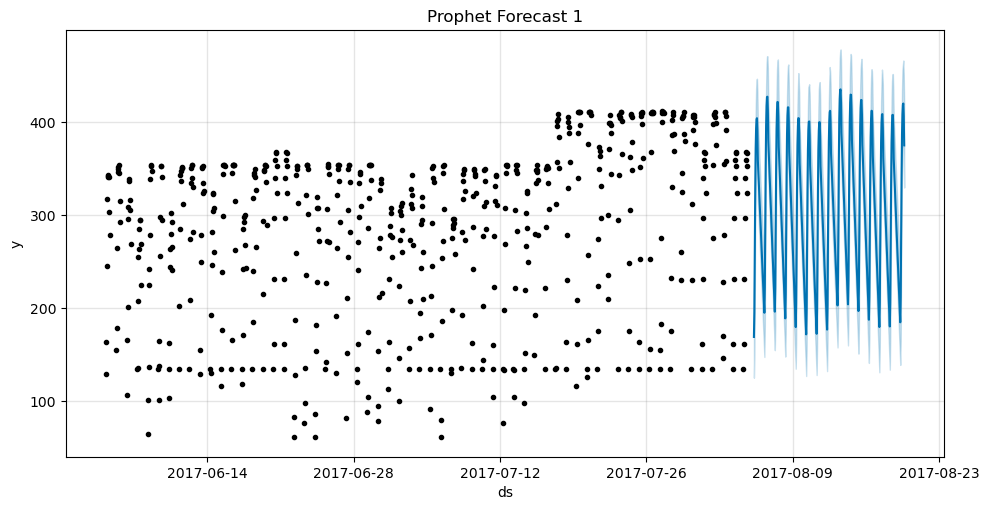

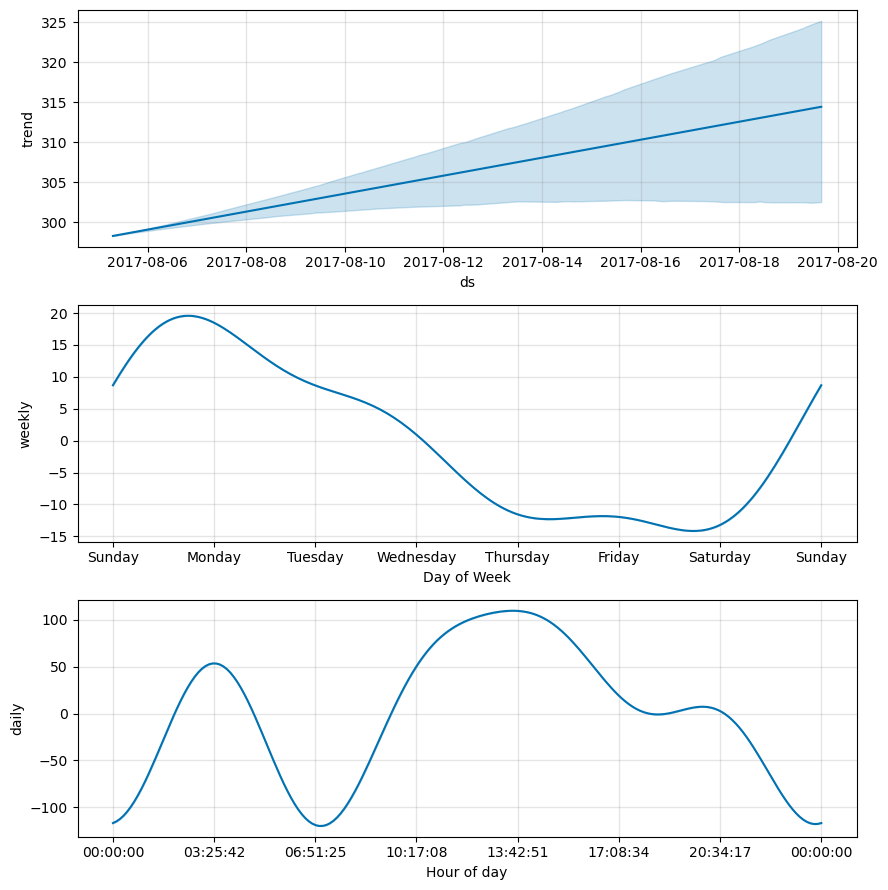

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

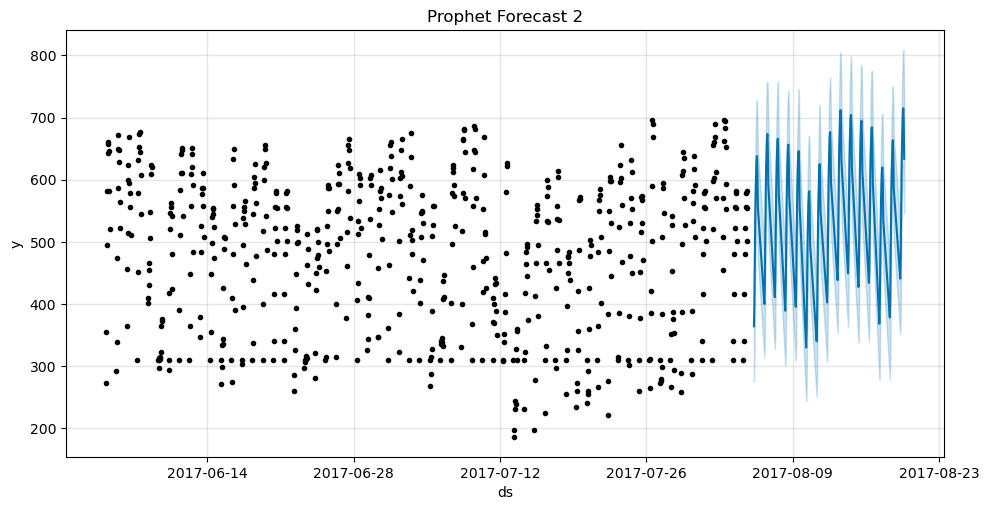

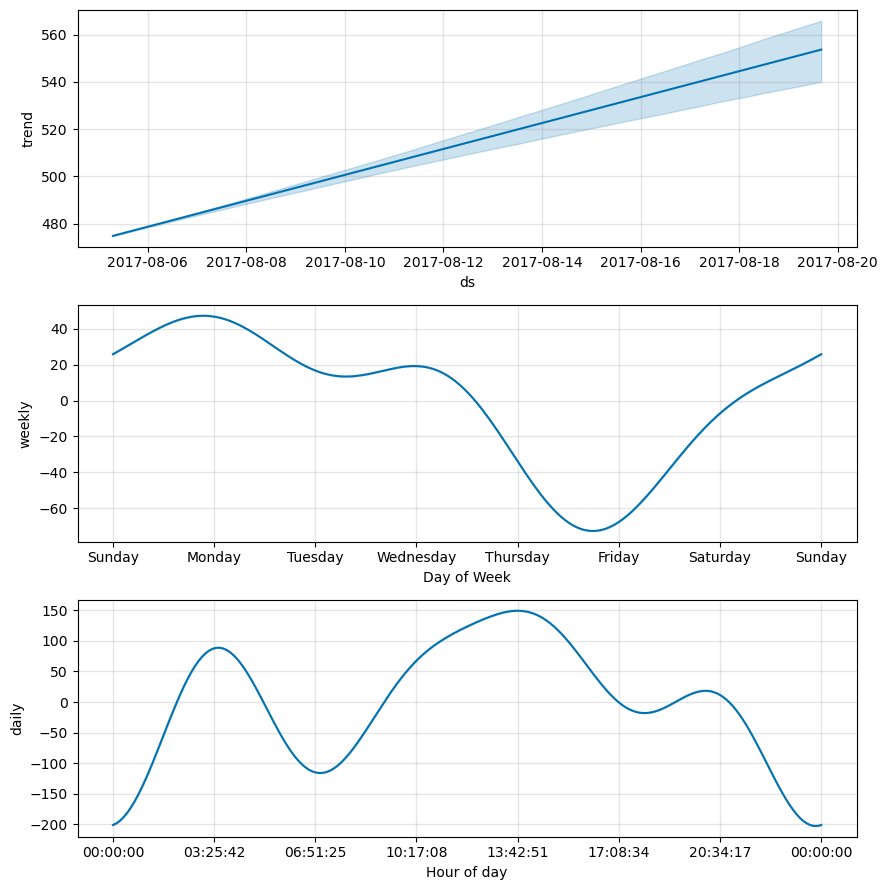

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

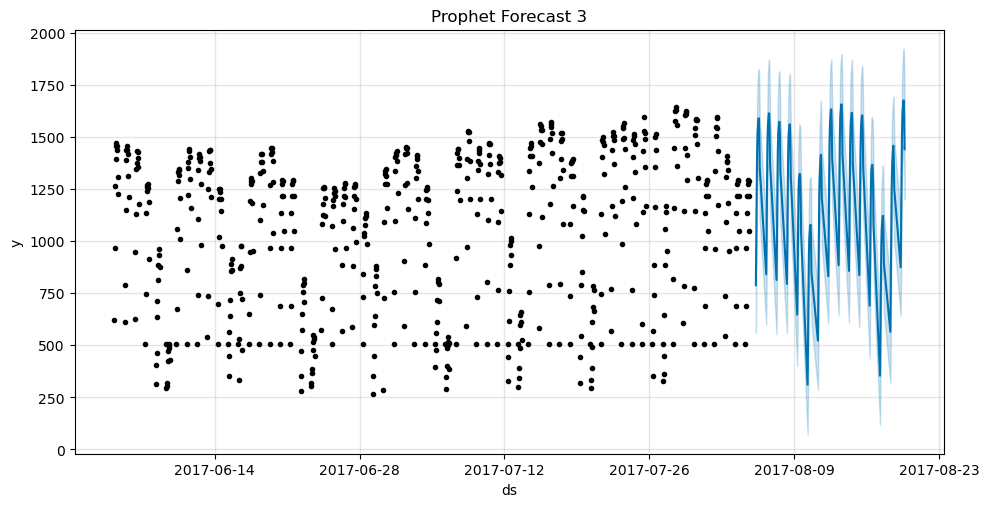

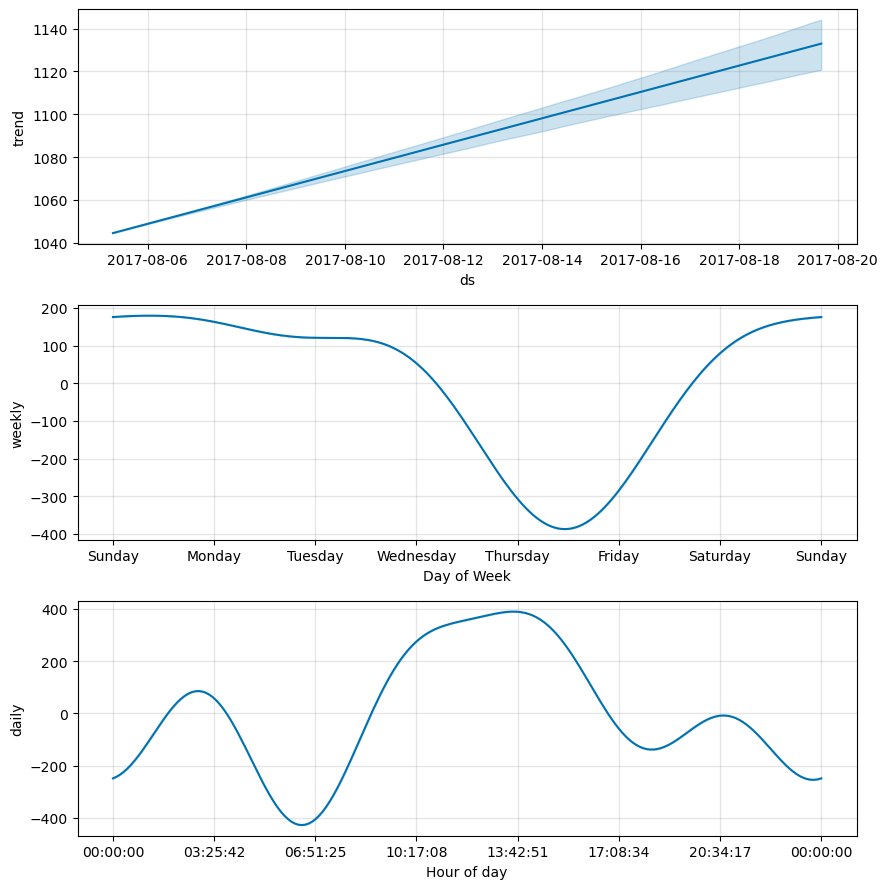

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

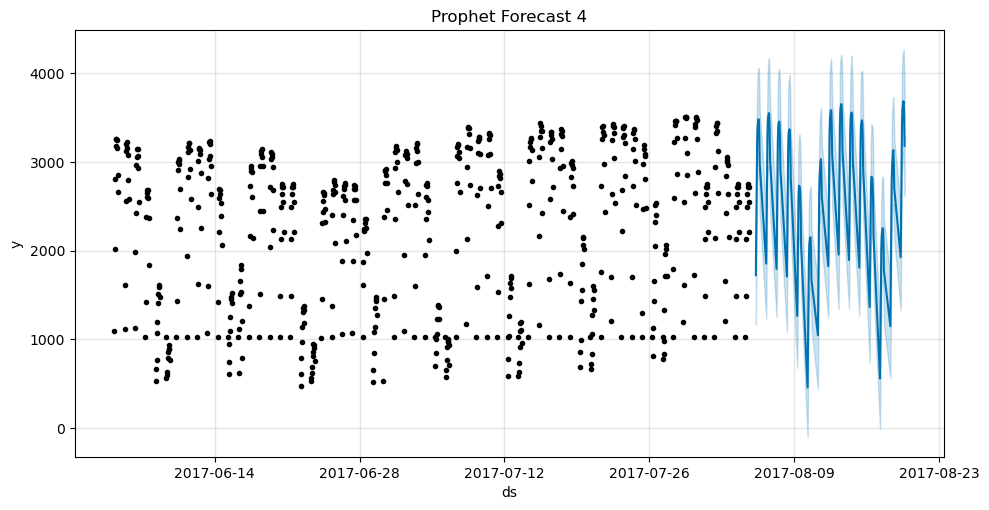

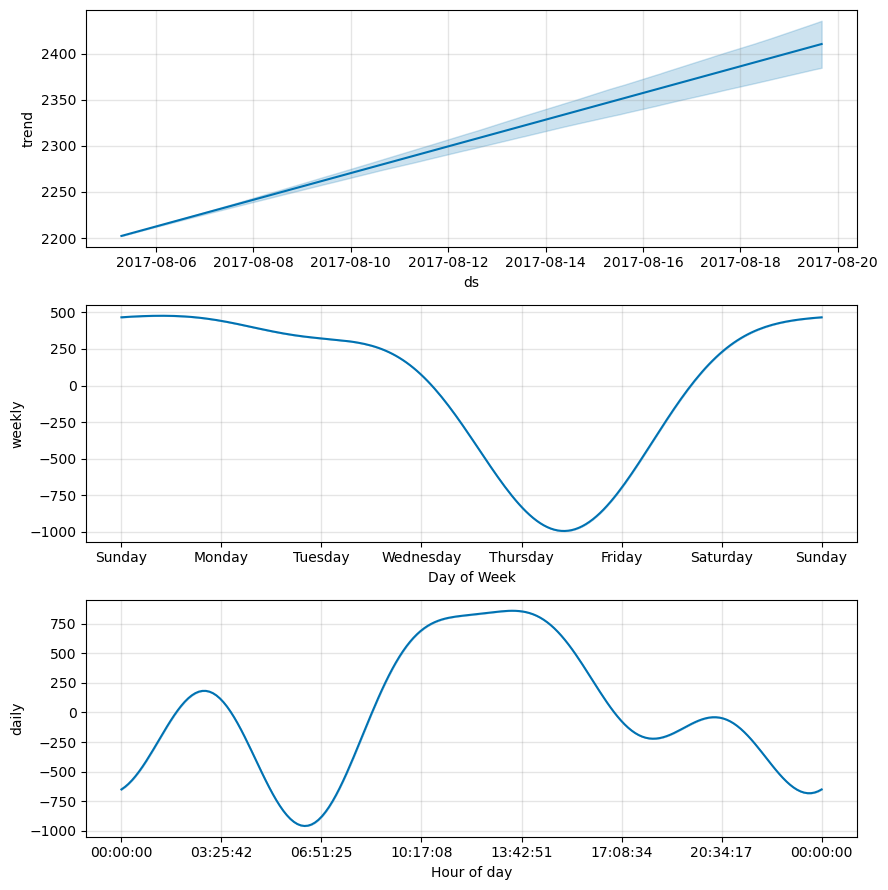

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

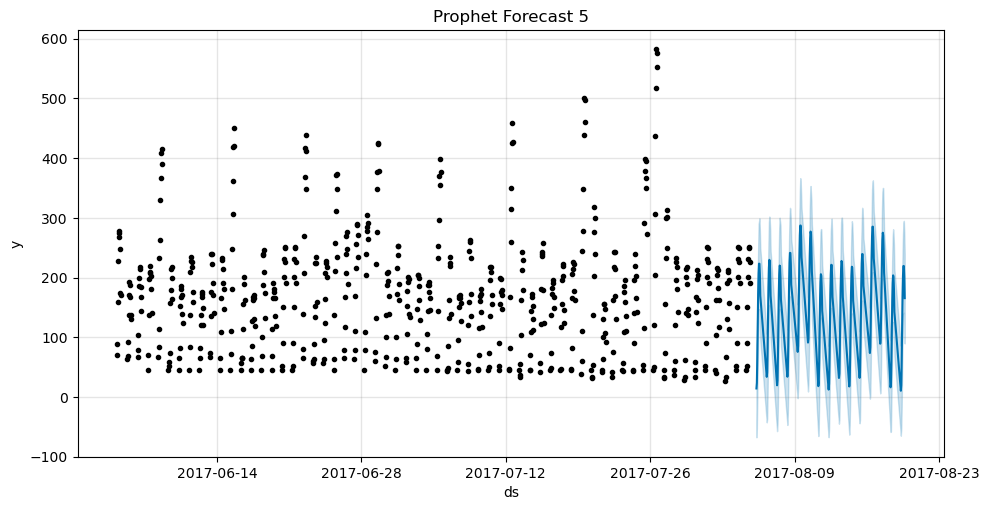

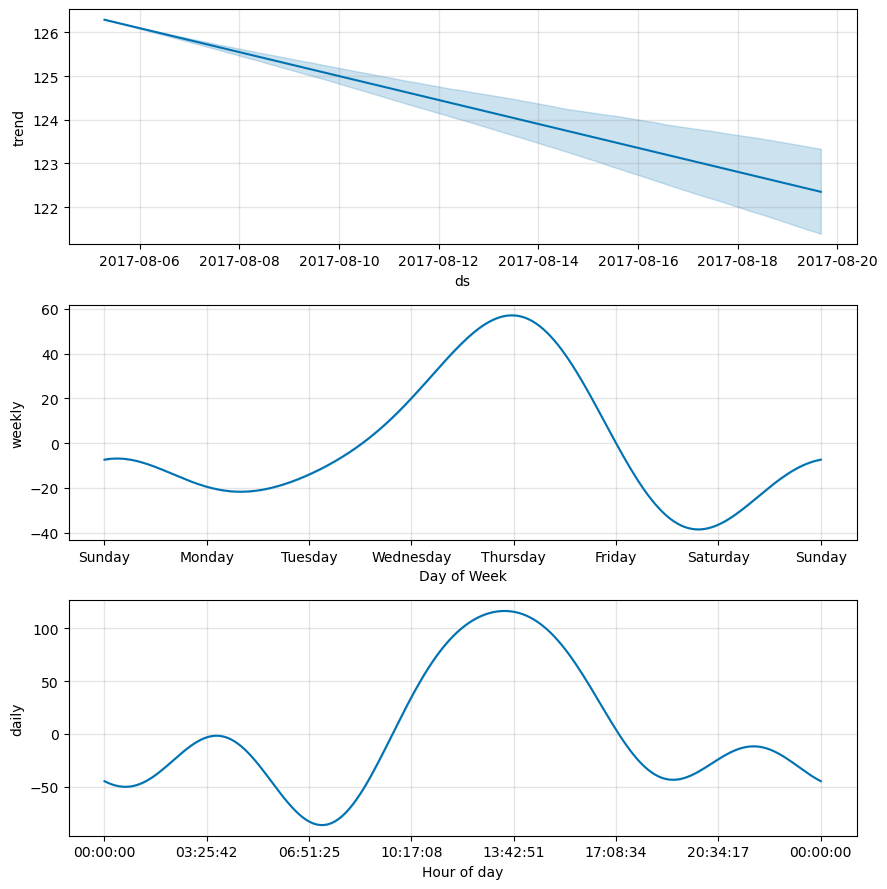

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

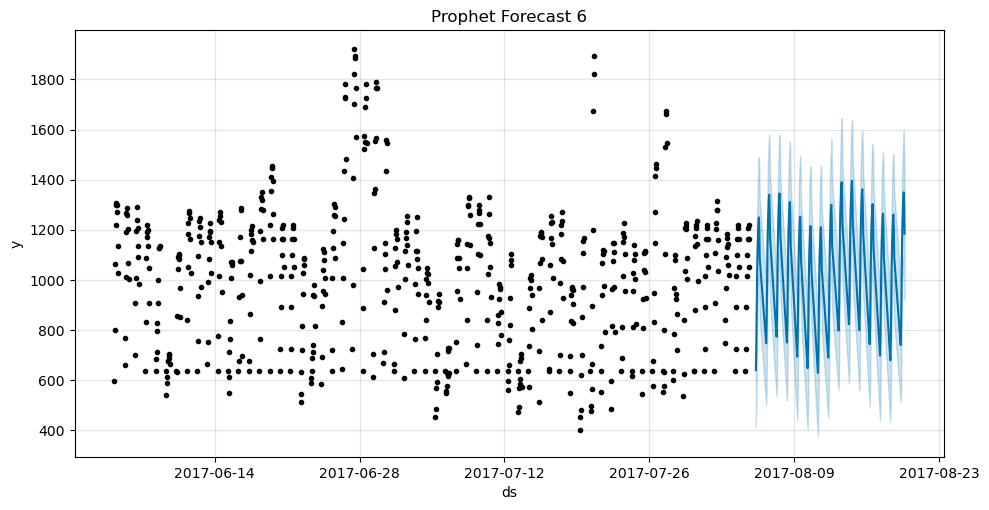

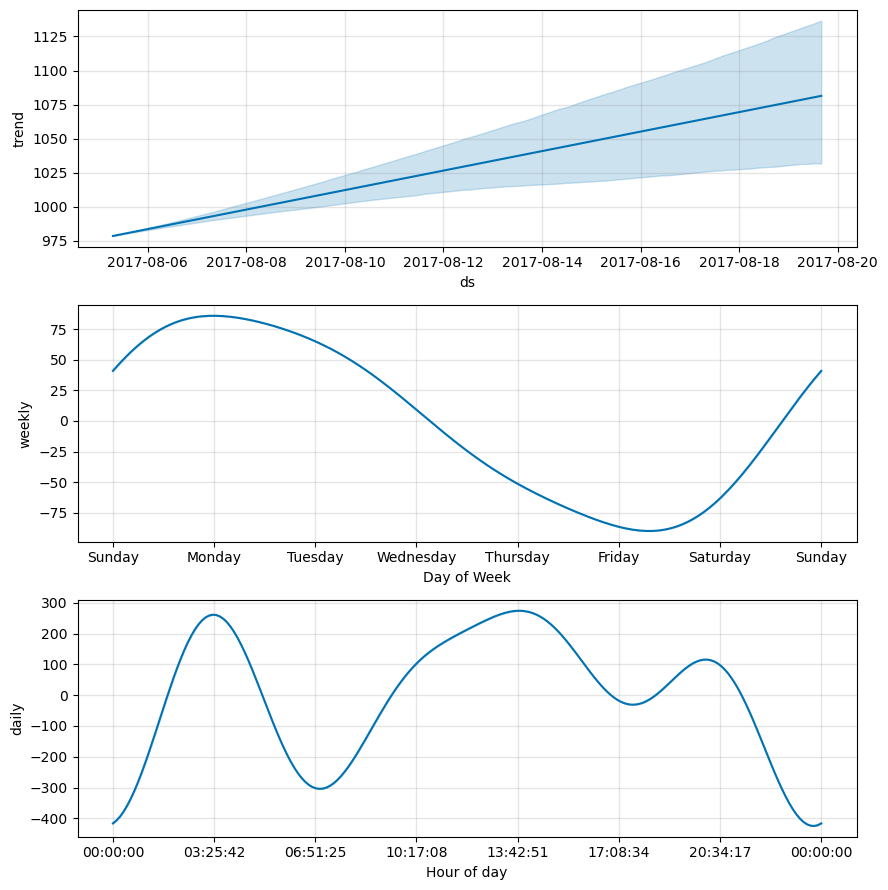

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

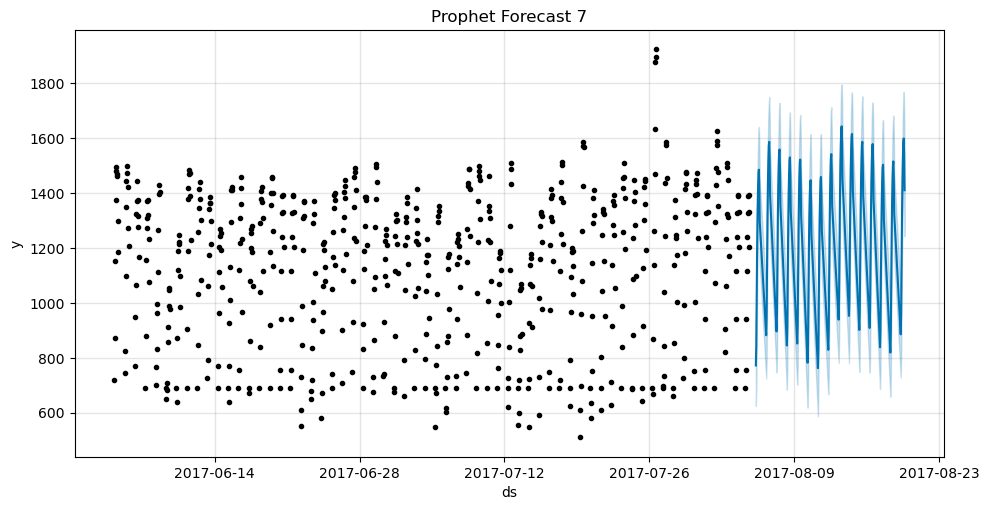

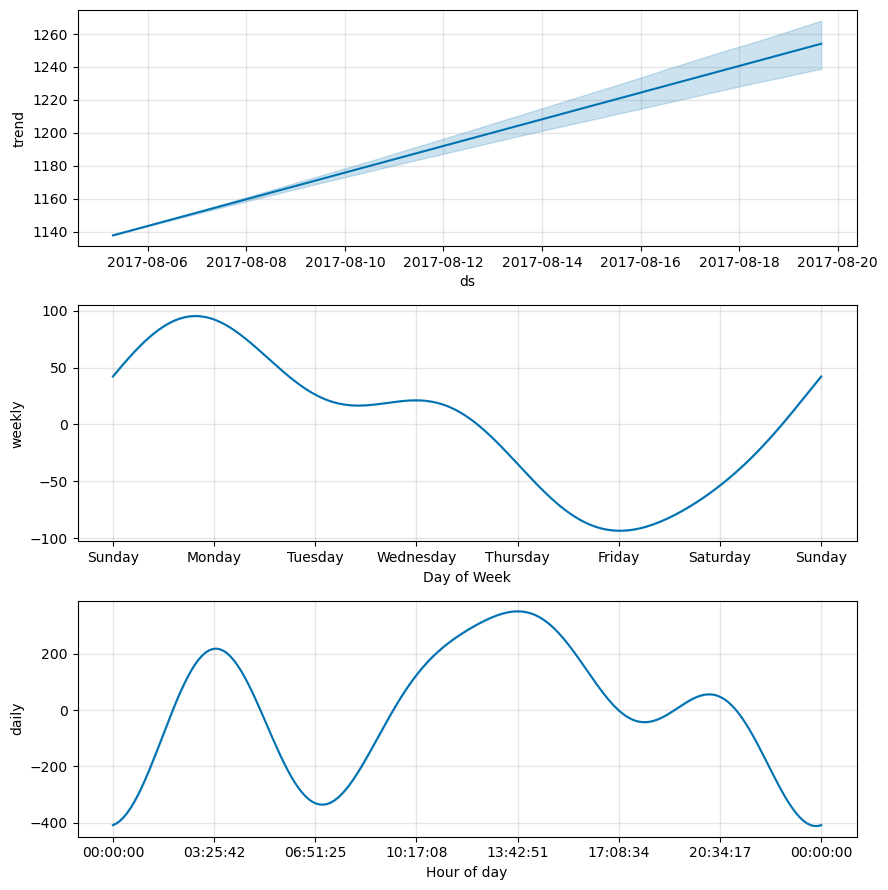

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

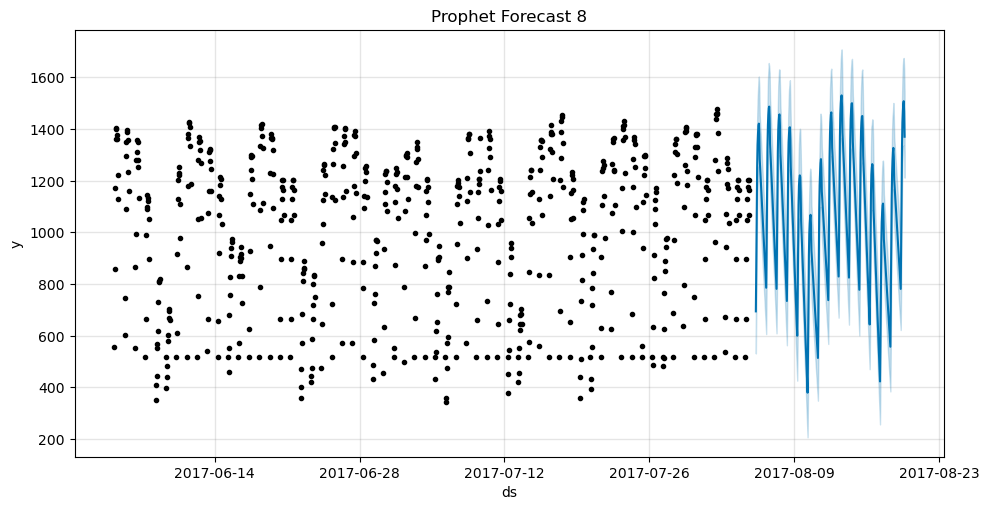

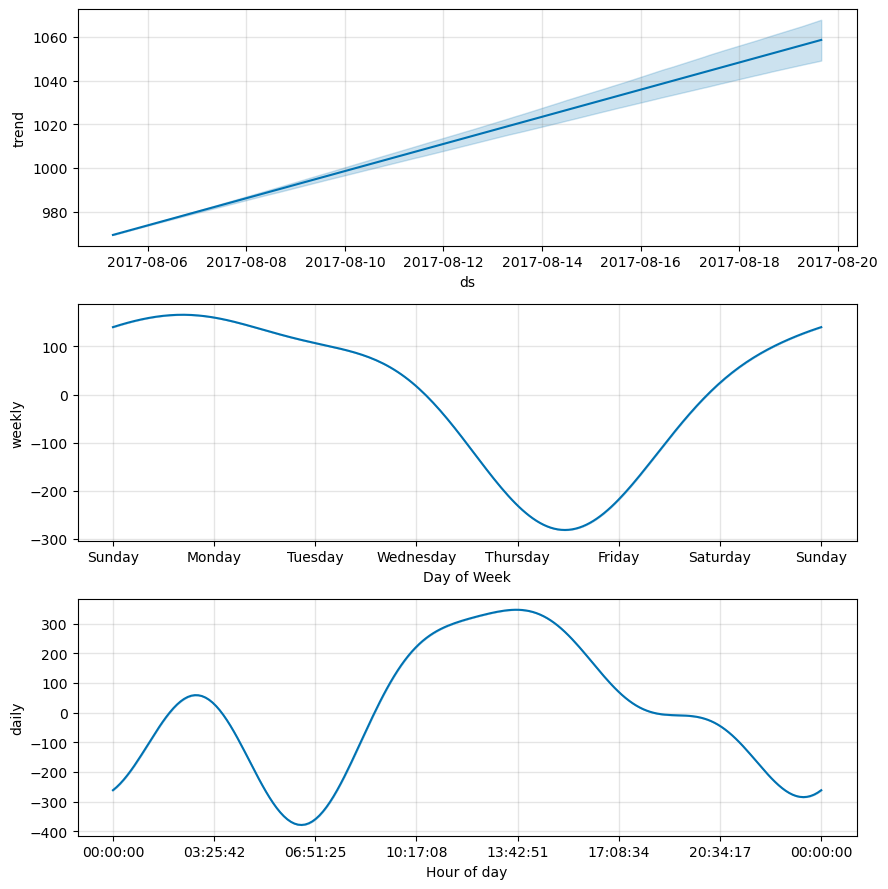

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\enes_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

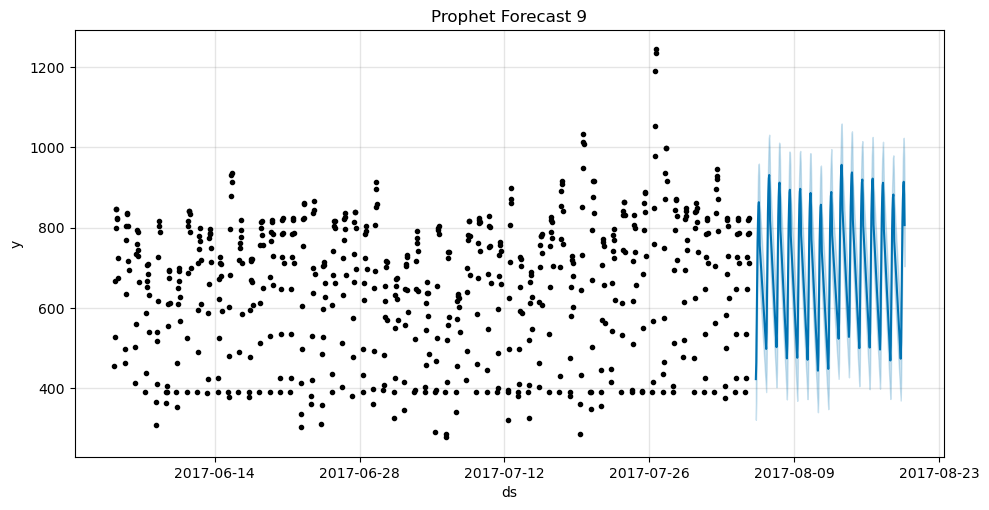

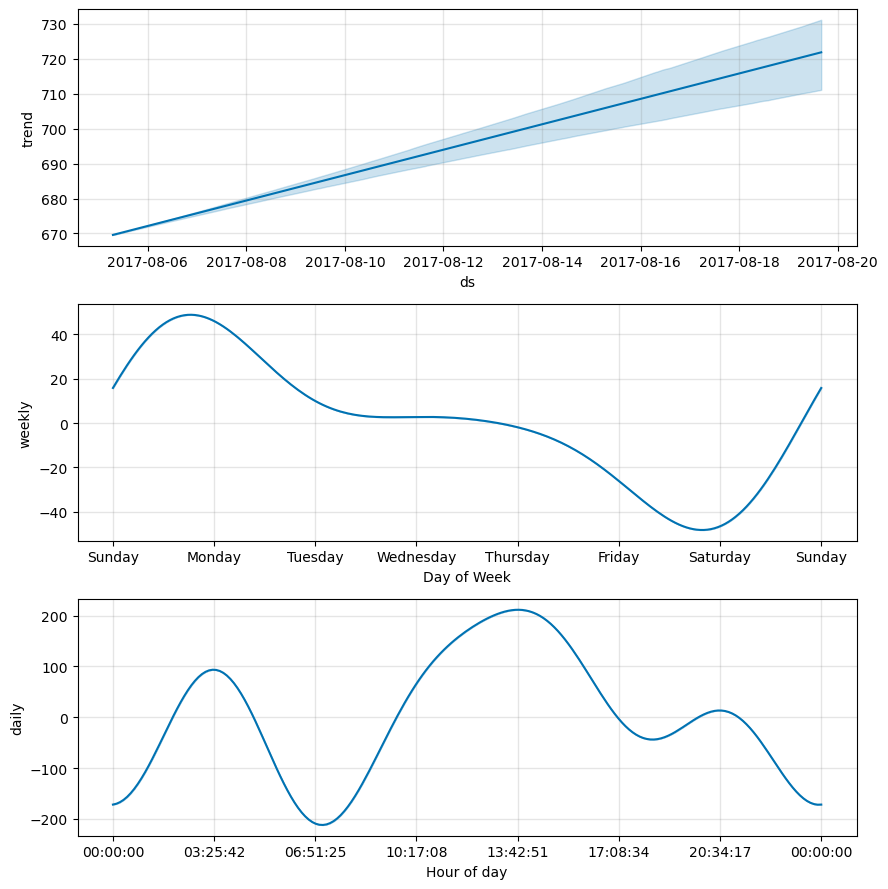

In [38]:
if __name__ == "__main__":
    data = pd.read_csv(r"data/municipality_bus_utilization.csv",header=0)
    check_df(data)

    data = selecet_max_usage_in_an_hour(data,TIME_COLUMN_NAME,MUNICIPALITY_COLUMN_NAME)

    temp = data[[TIME_COLUMN_NAME, MUNICIPALITY_COLUMN_NAME]].set_index(TIME_COLUMN_NAME) # All hours and municipality id
    rec_hours = temp[temp[MUNICIPALITY_COLUMN_NAME] == 0].loc[FIRST_DATE].index.hour # Working hours. (Between 7 am and 4 pm )

    missing_hours = find_missing_hours(data,TIME_COLUMN_NAME,MUNICIPALITY_COLUMN_NAME)
    missing_date = find_missing_dates(data,TIME_COLUMN_NAME)

    missing_df = create_missing_dataframe(missing_hours,TIME_COLUMN_NAME,MUNICIPALITY_COLUMN_NAME,USAGE_COLUMN_NAME)

    means = mean_each_hour(data,TIME_COLUMN_NAME,MUNICIPALITY_COLUMN_NAME,USAGE_COLUMN_NAME)

    clean_data = fill_all_missing_values(data,missing_df,means,TIME_COLUMN_NAME,MUNICIPALITY_COLUMN_NAME)

    save_clean_data_as_csv(clean_data,MUNICIPALITY_COLUMN_NAME)

    [prophet_model_predict_and_plot(i) for i in range(MUNICIPALITY_COUNT)]

In [ ]:
# TODO: Add performance metrics